In [15]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
%matplotlib inline
import os
from scipy.stats import gaussian_kde
import metpy.calc as mpcalc
from metpy.units import units
import matplotlib.dates as mdates
from matplotlib.pyplot import MultipleLocator

In [2]:
if os.environ['COMPUTERNAME'] == 'DESKTOP-EQAO3M5':
  computer_flag = 'home'
else:
  computer_flag = 'office'

if computer_flag == 'home':
  file_dir = "F:/github/pythonScript/seafog/"
else:
  file_dir = "H:/github/python/seafog/"

def randrange(n, vmin, vmax):
    """
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    """
    return (vmax - vmin)*np.random.rand(n) + vmin

def linear_vis(x):
    if(x <= 1000.0):
      y = x/1000.0
    elif(x > 1000.0 and x <= 10000.0):
      y = (x-1000.0)/9000.0 + 1.0
    elif( x > 10000.0  and x <= 30000.0):
      y = (x-10000.0)/20000 + 2.0
    else:
      y = 3.0
    return y

def reverse_linear_vis(x):
    if(x<0):
      y = 1
    elif(x <= 1.0):
      y = x*1000.0
    elif(x <= 2.0):
      y = (x - 1.0)*9000.0 + 1000.0
    elif(x <= 3.0):
      y = (x-2.0)*20000 + 10000.0
    else:
      y = 30000.0
    return y

In [3]:
file_59754 = os.path.normpath(os.path.join(file_dir, './data/station/59754.by_5min_20200101-20221029.csv')) # 读取徐闻站分钟级数据
df_59754 = pd.read_csv(file_59754,sep=',',na_values=[9999])
df_59754.index = pd.to_datetime(df_59754["DDATETIME"])

df_code = pd.read_csv(os.path.normpath(os.path.join(file_dir, './code_readme.csv')),sep=',')

C:\Users\Henry\AppData\Local\Temp\ipykernel_13804\673614758.py:2: DtypeWarning: Columns (12,112) have mixed types. Specify dtype option on import or set low_memory=False.
  df_59754 = pd.read_csv(file_59754,sep=',',na_values=[9999])


In [4]:
bjtime_index_59754 = df_59754.index.to_series() + pd.Timedelta(8,unit='h')
df_59754['bj_time'] = bjtime_index_59754

In [5]:
code_info = {
  'vis01':'V20059',
  'vis_01min':'V20001_701_01',
  'vis_10min':'V20001_701_10',
  'vis':'V20001',
  'td': 'V12003',
  't2m': 'V12001',
  "year":"V04001",
  "month": "V04002",
  "day": "V04003",
  "hour":"V04004",
  "minute":"V04005",
  "rhum":"V13003",
  'rain01':'V13019',
}

In [6]:
ds_G7425 = pd.read_hdf(os.path.normpath(os.path.join(file_dir, './data/G7425/G7425_202012to202209.hdf')), mode='r') # 浮标站数据

In [7]:
df_start_end = pd.read_csv(os.path.normpath(os.path.join(file_dir, './src/statistics/分钟级-开始结束时间.csv')))
df_start_end['start'] = pd.to_datetime(df_start_end['start'])
df_start_end['end'] = pd.to_datetime(df_start_end['end'])
print(df_start_end)

                 start                 end
0  2020-12-27 18:30:00 2020-12-27 23:55:00
1  2021-01-15 16:40:00 2021-01-15 19:25:00
2  2021-01-20 16:10:00 2021-01-20 16:35:00
3  2021-01-22 04:20:00 2021-01-22 05:25:00
4  2021-01-22 12:55:00 2021-01-23 04:35:00
5  2021-01-23 12:45:00 2021-01-25 02:05:00
6  2021-01-25 14:00:00 2021-01-26 00:10:00
7  2021-01-26 09:10:00 2021-01-27 00:45:00
8  2021-02-02 13:10:00 2021-02-02 23:30:00
9  2021-02-05 17:25:00 2021-02-05 22:50:00
10 2021-02-06 21:45:00 2021-02-06 23:20:00
11 2021-02-08 18:10:00 2021-02-08 19:35:00
12 2021-02-09 00:35:00 2021-02-09 19:05:00
13 2021-02-11 20:55:00 2021-02-12 00:55:00
14 2021-02-12 16:35:00 2021-02-13 00:45:00
15 2021-02-14 14:00:00 2021-02-15 00:25:00
16 2021-02-15 23:15:00 2021-02-16 00:00:00
17 2021-02-16 16:05:00 2021-02-17 01:25:00
18 2021-02-20 21:50:00 2021-02-21 00:05:00
19 2021-02-21 20:50:00 2021-02-22 00:05:00
20 2021-02-22 18:05:00 2021-02-23 00:10:00
21 2021-02-23 20:15:00 2021-02-24 00:05:00
22 2021-02-

In [8]:
df_timeline = df_59754.loc[df_start_end['start'][0] - pd.Timedelta(26,unit='h'):df_start_end['end'][0] + pd.Timedelta(26,unit='h')]

vis_01min_timeline = df_timeline[code_info['vis_01min']]
t2m_timeline = df_timeline[code_info['t2m']]
td_timeline = df_timeline[code_info['td']]
bjtime =  df_timeline['bj_time']
selected_G7425 = ds_G7425.loc[(ds_G7425['ObserveTime']>=bjtime[0]) & (ds_G7425['ObserveTime']<=bjtime[-1])]
time_G7425 = selected_G7425['ObserveTime']
sst_G7425 = selected_G7425['SeaTemperature']

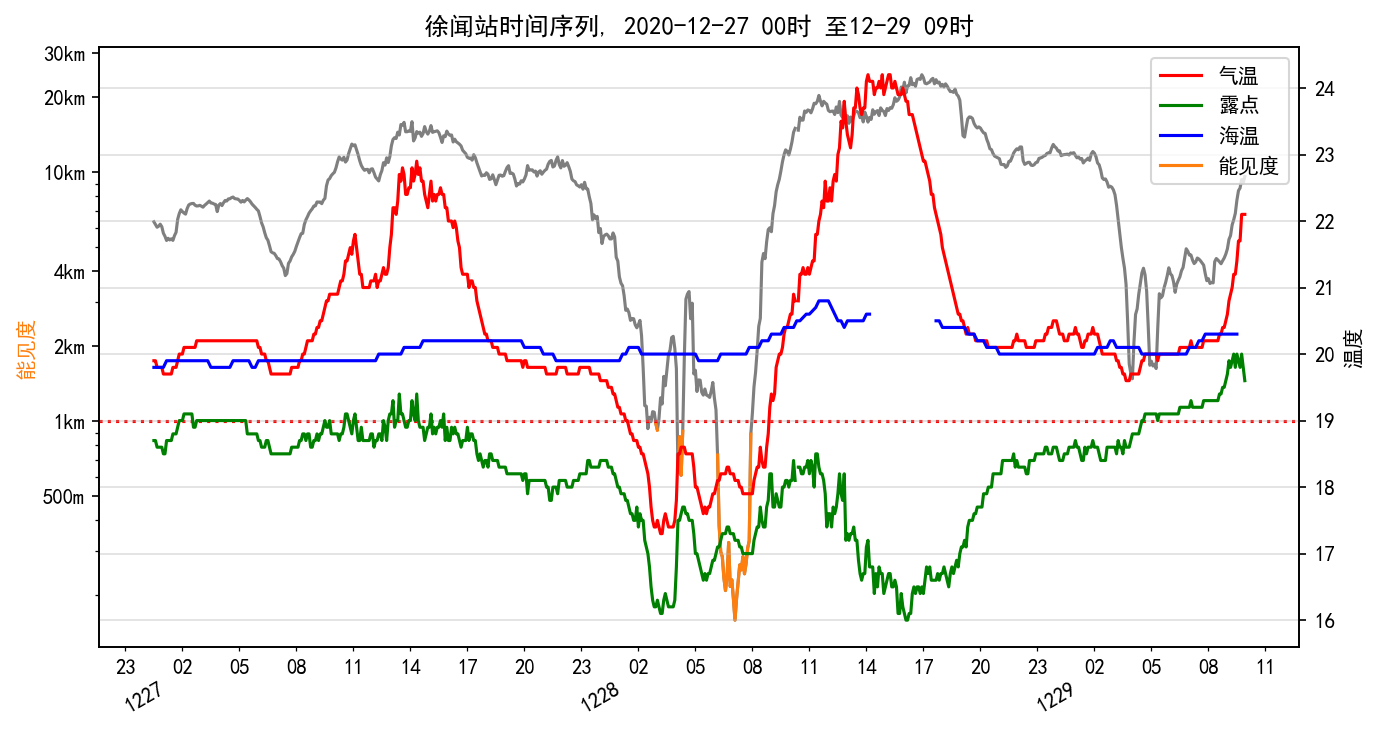

In [18]:
fig = plt.figure(figsize=(8,4), dpi=150)
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(bjtime, vis_01min_timeline, color='black', alpha=0.5,zorder=0)
# generate the masked array
vis_mask = np.ma.masked_greater(vis_01min_timeline.values, 1000)
line_vis, = ax.plot(bjtime, vis_mask, color='tab:orange', label='能见度', zorder=1)
ax.set_ylabel("能见度")
ax.yaxis.get_label().set_color('tab:orange')
ax.axhline(y=1000, color='r', linestyle=':')
ax.set_yscale('log')
ax.set_yticks([500, 1_000,2_000,4_000,10_000, 20_000, 30_000,])
ax.set_yticklabels(['500m','1km','2km','4km','10km','20km','30km'])
# 第二个坐标
ax2 = ax.twinx()
line_t2m, = ax2.plot(bjtime, t2m_timeline, color='r', label='2m气温', zorder=2)
line_td, = ax2.plot(bjtime, td_timeline,   color='g',  label='露点'  , zorder=3)
line_sst, = ax2.plot(time_G7425, sst_G7425,   color='b',   label='海温', zorder=4)

# 设置x轴主刻度格式
alldays = mdates.DayLocator()  # 主刻度为每天
ax.xaxis.set_major_locator(alldays)  # 设置主刻度
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m%d'))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

# 设置副刻度格式
hoursLoc = mpl.dates.HourLocator(byhour=[2, 5, 8, 11, 14, 17, 20,23])  # 为6小时为1副刻度
ax.xaxis.set_minor_locator(hoursLoc)
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
# 参数pad用于设置刻度线与标签间的距离
ax.tick_params(axis='x', which='major', pad=15, length=0)

ax2.yaxis.set_major_locator(MultipleLocator(1))
ax2.grid(True,alpha=0.4)
ax.set_title(f"徐闻站时间序列, {bjtime[0].strftime('%Y-%m-%d %H时')} 至{bjtime[-1].strftime('%m-%d %H时')}")
ax2.set_xlabel("北京时")
ax2.set_ylabel("温度")
plt.legend([line_t2m, line_td, line_sst, line_vis], ['气温', '露点', '海温', '能见度'])
plt.show()

In [ ]:
def drawPlot():
  df_timeline = df_59754.loc[df_start_end['start'][0] - pd.Timedelta(26,unit='h'):df_start_end['end'][0] + pd.Timedelta(26,unit='h')]
  
  vis_01min_timeline = df_timeline[code_info['vis_01min']]
  t2m_timeline = df_timeline[code_info['t2m']]
  td_timeline = df_timeline[code_info['td']]
  bjtime =  df_timeline['bj_time']
  selected_G7425 = ds_G7425.loc[(ds_G7425['ObserveTime']>=bjtime[0]) & (ds_G7425['ObserveTime']<=bjtime[-1])]
  time_G7425 = selected_G7425['ObserveTime']
  sst_G7425 = selected_G7425['SeaTemperature']

In [19]:
# TODO for循环, 保持页面
for index in range(len(df_start_end)):
  start = df_start_end['start'][index]
  end =  df_start_end['end'][index]
  df_timeline = df_59754.loc[start - pd.Timedelta(26,unit='h'):end + pd.Timedelta(26,unit='h')]
  
  vis_01min_timeline = df_timeline[code_info['vis_01min']]
  t2m_timeline = df_timeline[code_info['t2m']]
  td_timeline = df_timeline[code_info['td']]
  bjtime =  df_timeline['bj_time']
  selected_G7425 = ds_G7425.loc[(ds_G7425['ObserveTime']>=bjtime[0]) & (ds_G7425['ObserveTime']<=bjtime[-1])]
  time_G7425 = selected_G7425['ObserveTime']
  sst_G7425 = selected_G7425['SeaTemperature']

  fig = plt.figure(figsize=(8,4), dpi=150)
  ax = fig.add_axes([0, 0, 1, 1])
  ax.plot(bjtime, vis_01min_timeline, color='black', alpha=0.5,zorder=0)
  # generate the masked array
  vis_mask = np.ma.masked_greater_equal(vis_01min_timeline.values, 1000)
  line_vis, = ax.plot(bjtime, vis_mask, color='tab:orange', label='能见度', zorder=1)
  ax.set_ylabel("能见度")
  ax.yaxis.get_label().set_color('tab:orange')
  ax.axhline(y=1000, color='r', linestyle=':')
  ax.set_yscale('log')
  ax.set_yticks([500, 1_000,2_000,4_000,10_000, 20_000, 30_000,])
  ax.set_yticklabels(['500m','1km','2km','4km','10km','20km','30km'])
  # 第二个坐标
  ax2 = ax.twinx()
  line_t2m, = ax2.plot(bjtime, t2m_timeline, color='r', label='2m气温', zorder=2)
  line_td, = ax2.plot(bjtime, td_timeline,   color='g',  label='露点'  , zorder=3)
  line_sst, = ax2.plot(time_G7425, sst_G7425,   color='b',   label='海温', zorder=4)

  # 设置x轴主刻度格式
  alldays = mdates.DayLocator()  # 主刻度为每天
  ax.xaxis.set_major_locator(alldays)  # 设置主刻度
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%m%d'))
  ax.xaxis.set_tick_params(rotation=30, labelsize=10)

  # 设置副刻度格式
  hoursLoc = mpl.dates.HourLocator(byhour=[2, 5, 8, 11, 14, 17, 20,23])  # 为6小时为1副刻度
  ax.xaxis.set_minor_locator(hoursLoc)
  ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
  # 参数pad用于设置刻度线与标签间的距离
  ax.tick_params(axis='x', which='major', pad=15, length=0)
  ax2.grid(True,alpha=0.4)
  ax.set_title(f"No{index+1} 徐闻站时间序列, {bjtime[0].strftime('%Y-%m-%d %H时')} 至{bjtime[-1].strftime('%m-%d %H时')}")
  ax2.set_xlabel("北京时")
  ax2.set_ylabel("温度")
  ax2.yaxis.set_major_locator(MultipleLocator(1))
  plt.legend([line_t2m, line_td, line_sst, line_vis], ['气温', '露点', '海温', '能见度'])
  imgDir = os.path.join(file_dir, f'./img/timeline_minute/')
  imgDir = os.path.normpath(imgDir)
  imgName = f"timeSeries_Fog_{start.strftime('%Y-%m-%d_%H_%M')}.jpg"
  imgPath = os.path.join(imgDir, imgName)
  plt.savefig(imgPath, format='jpg', bbox_inches='tight', transparent=True)
  print('保存图片: ' + imgPath)
  plt.close(fig)

保存图片: F:\github\pythonScript\seafog\img\timeline_minute\timeSeries_Fog_2020-12-27_18_30.jpg
保存图片: F:\github\pythonScript\seafog\img\timeline_minute\timeSeries_Fog_2021-01-15_16_40.jpg
保存图片: F:\github\pythonScript\seafog\img\timeline_minute\timeSeries_Fog_2021-01-20_16_10.jpg
保存图片: F:\github\pythonScript\seafog\img\timeline_minute\timeSeries_Fog_2021-01-22_04_20.jpg
保存图片: F:\github\pythonScript\seafog\img\timeline_minute\timeSeries_Fog_2021-01-22_12_55.jpg
保存图片: F:\github\pythonScript\seafog\img\timeline_minute\timeSeries_Fog_2021-01-23_12_45.jpg
保存图片: F:\github\pythonScript\seafog\img\timeline_minute\timeSeries_Fog_2021-01-25_14_00.jpg
保存图片: F:\github\pythonScript\seafog\img\timeline_minute\timeSeries_Fog_2021-01-26_09_10.jpg
保存图片: F:\github\pythonScript\seafog\img\timeline_minute\timeSeries_Fog_2021-02-02_13_10.jpg
保存图片: F:\github\pythonScript\seafog\img\timeline_minute\timeSeries_Fog_2021-02-05_17_25.jpg
保存图片: F:\github\pythonScript\seafog\img\timeline_minute\timeSeries_Fog_2021-02-0